In [ ]:
import numpy as np
import qmt
import imt
import ring
from imt.utils.view import view
from imt.utils.view import VisOptions
import matplotlib.pyplot as plt
import tree
import pandas as pd
import quaternion_angle as qa
from pathlib import Path
import os


In [ ]:
# LOAD DATA
folder_data_imu = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Dict_Frames/"
folder_data_cam = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/Daten/IMU/Knee_angle2d/"
filenames_imu = [str(f) for f in Path(folder_data_imu).rglob('*') if f.is_file()]  # all filnames in array
filenames_cam = [str(f) for f in Path(folder_data_cam).rglob('*') if f.is_file()]
sensors = ["S0333", "S1094", "S0593", "S0994", "S0477"]
cam_seq = [17, 16, 17, 18, 2291, 16, 16, 15, 15, 17, 21, 21, 19, 23, 19, 26, 21, 589, 23, 20, 20, 17, 22, 21, 18, 20, 18, 17, 20, 23, 23, 18, 20, 0, 14, 19, 17, 18, 270, 17, 18, 19, 19, 17, 20] # Startzeitpunkt in Kamera sequenzen
#cam_seq_0 = [17, 17, 16, 17, 18, 2291, 16, 16, 15, 15, 17, 21, 21, 19, 23, 19, 26, 21, 589, 23, 20, 20, 17, -300, 19, 22, 21, 18, 20, 18, 15, 17, 20, 18, 23, 23, 18, 20, 0, 17, 14, 19, 17, 18, 270, 17, 18, 19, 19, 17, 20, 20] # 1 und 41 ohne Sternum,25 rot, 26 S0194 fehlt, 53 keine Kamera datei, 35 S0994 fehlt, 18 fehlt, ab 54: 21, 21, 17, 110, 0, 46, 140, 40]

Hz = 52
Hz_resample = 30 # Kamera sample Rate
Ts=0.01

In [ ]:
qhat_all = []
extras_all = []
#angle_kr_all = []
#angle_kl_all = []
qa_kr_all = []
qa_kl_all = []
angle_cam_kr_all = []
angle_cam_kl_all = []
ts_resample_all = []
ts_camera2d_all = []

for i_seq in (27,28):#range(2):#len(filenames_imu)):
    # LOAD DATA
    data_imu_seq = np.load(filenames_imu[i_seq], allow_pickle=True).item()
    data_cam_both_seq = np.loadtxt(filenames_cam[i_seq], delimiter=",") # Kniewinkel aus Videodaten beide Beine
    data_cam_kr_seq = data_cam_both_seq[:,1][cam_seq[i_seq]:]      # [:,1] nur Knie rechts, [:,0] nur Knie links
    data_cam_kl_seq = data_cam_both_seq[:,0][cam_seq[i_seq]:]      # [i:] alles vor index i entfernen

    # PREPARE DATA
    imu_data = {
        i: dict(acc=data_imu_seq[sensors[i]]["acc"], gyr=data_imu_seq[sensors[i]]["gyr_rad"])
        for i in range(len(sensors))  
        }
    imu_data = imt.utils.resample(imt.utils.crop_tail(imu_data, Hz), Hz, 1/Ts)

    imu_data[0] = dict(
        acc=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["acc"]),
        gyr=qmt.rotate(qmt.quatFromAngleAxis(-np.pi, [0, 0, 1]), imu_data[0]["gyr"]),
    )
    
    # ESTIMATE ORIENTATIONS
    rel_method = imt.methods.RING(axes_directions=np.array([1.0, 0, 0]))
    graph = [-1, 0, 1, 0, 3]
    solver = imt.Solver(graph, [imt.methods.VQF(offline=True)] +
                        #[imt.wrappers.JointTracker1D(rel_method)]*4, 
                        [rel_method]*4, 
                        Ts=Ts)
    qhat, extras = solver.step(imu_data)
    qhat_all.append(qhat)
    extras_all.append(extras)

    q1 = qhat[1]
    q2 = qhat[2] 
    q3 = qhat[3] 
    q4 = qhat[4] 
    # Compute angles
    qa_kr = qa.quaternion_angle(q1, q2)
    qa_kl = qa.quaternion_angle(q3, q4)  

    # Extract timesteps
    T = qhat[0].shape[0]
    ts = np.round(np.arange(T)*Ts, 2)
    # Extract measruement values
    #angle_kr = -np.rad2deg(extras[2]["joint_angle_rad"])
    #angle_kl = -np.rad2deg(extras[4]["joint_angle_rad"])

    ts_camera2d = np.round(np.arange(len(data_cam_kr_seq))*(1/Hz_resample), 3) # timesteps for camera data with camera sample rate
    # DOWNSAMPLE IMU DATA KNEE ANGLE RATE TO CAMERA SAMPLE RATE
    factor = (1/Ts)/Hz_resample
    indices = np.round(np.arange(0, len(ts), factor), 1)  # Select every nth index
    ts_resample = np.round(np.interp(indices, np.arange(len(ts)), ts), 3)
    #angle_kr_resample = np.interp(indices, np.arange(len(ts)), angle_kr)
    #angle_kl_resample = np.interp(indices, np.arange(len(ts)), angle_kl)
    qa_kr_resample = np.interp(indices, np.arange(len(ts)), qa_kr)  
    qa_kl_resample = np.interp(indices, np.arange(len(ts)), qa_kl)  

    #angle_kr_all.append(angle_kr_resample)
    #angle_kl_all.append(angle_kl_resample)
    qa_kr_all.append(qa_kr_resample)
    qa_kl_all.append(qa_kl_resample)
    angle_cam_kr_all.append(data_cam_kr_seq)
    angle_cam_kl_all.append(data_cam_kl_seq)
    ts_resample_all.append(ts_resample)
    ts_camera2d_all.append(ts_camera2d)




`crop_tail`: Crop off at t=180.07692307692307s
`crop_tail`: Crop off at t=182.76923076923077s


In [ ]:
# SAVE RESULTS
folder_path = "C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/imt-main/examples/results" 
os.makedirs(folder_path, exist_ok=True) # check if directory exists

np.save(os.path.join(folder_path, "Angles_IMU_RING_Knee_Left.npy"), np.array(qa_kl_all, dtype=object))  # Save files to results path
np.save(os.path.join(folder_path, "Angles_IMU_RING_Knee_Right.npy"), np.array(qa_kr_all, dtype=object))
np.save(os.path.join(folder_path, "Angles_CAM_Knee_Left.npy"), np.array(angle_cam_kl_all, dtype=object))
np.save(os.path.join(folder_path, "Angles_CAM_Knee_Right.npy"), np.array(angle_cam_kr_all, dtype=object))
np.save(os.path.join(folder_path, "Timesteps_RING.npy"), np.array(ts_resample_all, dtype=object))
np.save(os.path.join(folder_path, "Timesteps_CAM.npy"), np.array(ts_camera2d_all, dtype=object))

print(f"Saved successfully to: {folder_path}")

Saved successfully to: C:/Users/kubil/Documents/STUDIUM/Master/4_Masterarbeit_Code/IOE-Algo-compare/imt-main/examples/results


In [19]:
load_imu_kr = np.load(os.path.join(folder_path, "Angles_IMU_RING_Knee_Right.npy"), allow_pickle=True)

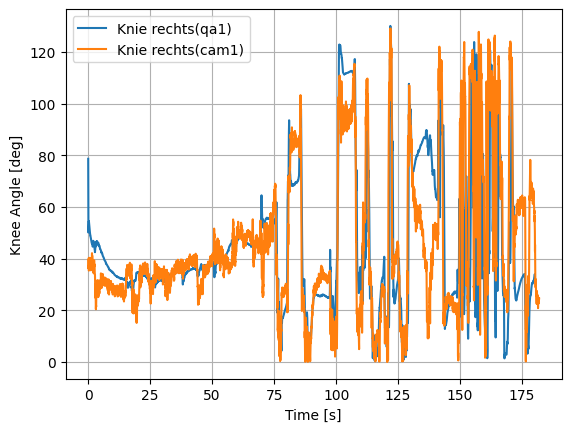

In [20]:
#plt.plot(ts_resample, angle_kr_resample, label="Knie rechts") 
#plt.plot(ts_resample, qa_kr_resample, label="Knie rechts(qa)") 
#plt.plot(ts_camera2d, data_camera2d_kr, label="Knie rechts camera2d")
plt.plot(ts_resample_all[0], load_imu_kr[0], label="Knie rechts(qa1)") 
#plt.plot(ts_resample_all[1], qa_kr_all[1], label="Knie rechts(qa2)") 
plt.plot(ts_camera2d_all[0], angle_cam_kr_all[0], label="Knie rechts(cam1)") 
#plt.plot(ts_camera2d_all[1], angle_cam_kr_all[1], label="Knie rechts(cam2)") 
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

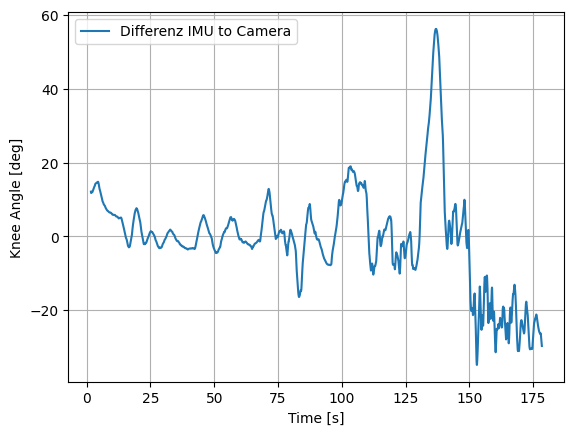

In [82]:
smoothed_arr = pd.Series(qa_kr_all[0]).rolling(window=100, center=True).mean().to_numpy()
smoothed_arr2 = pd.Series(angle_cam_kr_all[0][:len(qa_kr_all[0])]).rolling(window=100, center=True, min_periods=1).mean().to_numpy()
imu_to_camera2d_diff = smoothed_arr - smoothed_arr2
#for i in range(len(smoothed_arr)):
#    if smoothed_arr[i]<smoothed_arr2[i]:
#        imu_to_camera2d_diff[i] = smoothed_arr2[i] - smoothed_arr[i]

#imu_to_camera2d_diff = angle_kr_resample - data_camera2d_kr[:len(angle_kr_resample)]
#for i in range(len(angle_kr_resample)):
#    if angle_kr_resample[i] < data_camera2d_kr[:len(angle_kr_resample)][i]:
#        imu_to_camera2d_diff[i] = data_camera2d_kr[:len(angle_kr_resample)][i] - angle_kr_resample[i]
#smoothed_arr_itcd = pd.Series(imu_to_camera2d_diff).rolling(window=100, center=True).mean().to_numpy()

plt.plot(ts_resample_all[0], imu_to_camera2d_diff, label="Differenz IMU to Camera")
plt.grid()
plt.legend()
plt.ylabel("Knee Angle [deg]")
plt.xlabel("Time [s]")
plt.show()

In [83]:
rmse_value3 = np.sqrt(np.mean((qa_kr_all[0] - angle_cam_kr_all[0][:len(qa_kr_all[0])]) ** 2))
print(f"RMSE: {rmse_value3:.4f}")

RMSE: 21.3623
